# Diagnosing Heart Disease through Serum Cholesterol Levels and Resting Blood Pressure

DSCI 100 Group 30 Project

Group Members: Ziming Zhang, Alexander Tracey, Albert Guo, Kevin Butchart

## Introduction

Currently, the leading cause of death is heart disease, which is responsible for 16% of the world’s total deaths.  Any improvements in the rate of diagnosis (and therefore treatment) of heart-related issues will have a massive effect on global well-being.  Unfortunately, the medical equipment most often used to diagnose heart problems, X-rays and ECGs, are too expensive, unavailable, or infeasible to be used in much of the world. **This project aims to determine if cases of heart disease can be accurately classified using age, resting blood pressure, and serum cholesterol.** These specific parameters have been chosen because they can be measured at a fraction of the cost and effort required to produce X-ray or ECG results. The dataset used was donated by researchers at the Department of Medicine, Veterans Administration Medical Center, Long Beach, California in 1988. It compiled data of various patient test groups from America, Hungary and Switzerland, and proposed an algorithm using the data that could be used to identify heart disease. 

## Method & Results

### Load Data

In [2]:
install.packages("gridExtra")
install.packages("kknn")
library(tidyverse)
library(tidymodels)
library(gridExtra)
library(RColorBrewer)
library(kknn)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



The data was obtained from Kaggle (https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset). We uploaded it to Github and used the URL to read the data.

In [3]:
data <- read_csv("https://raw.githubusercontent.com/zzziminger/dsci100_004_group30/main/heart.csv")

Rows: 1025 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
head(data)

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
58,0,0,100,248,0,0,122,0,1.0,1,0,2,1


### Wrangling & Cleaning

In [5]:
data <- data |>
    mutate(target = as_factor(target),
          sex = as_factor(sex),
          age = as.integer(age),
          target = fct_recode(target, "disease" = "1", "no_disease" = "0"),
          sex = fct_recode(sex, "female" = "0", "male" = "1")) |>
    select(age, sex, trestbps, chol, target)

In [6]:
head(data)

age,sex,trestbps,chol,target
<int>,<fct>,<dbl>,<dbl>,<fct>
52,male,125,212,no_disease
53,male,140,203,no_disease
70,male,145,174,no_disease
61,male,148,203,no_disease
62,female,138,294,no_disease
58,female,100,248,disease


### Preliminary Analysis

In [7]:
#Split into training and testing datasets
set.seed(2023)
heart_split <- initial_split(data, prop = 0.75, strata = target)  
training_set <- training(heart_split)   
testing_set <- testing(heart_split)

In [8]:
#Check if there are missing values or not
identical(training_set, na.omit(training_set))

[1] TRUE

Since the datasets are the same before and after dropping the missing (NA) values, we can say that there are no missing values in the training set. Then, we create some summarize tables to demonstrate our dataset:

In [9]:
#The mean value for each potantial predictors
mean_predictors <- training_set |>
    select(age, trestbps, chol) |>
    map_df(mean)
mean_predictors

age,trestbps,chol
<dbl>,<dbl>,<dbl>
54.39974,131.5755,245.5677


In [10]:
#Number of diseases
disease <- training_set |>
    group_by(target) |>
    summarize(count = n())
disease

target,count
<fct>,<int>
no_disease,374
disease,394


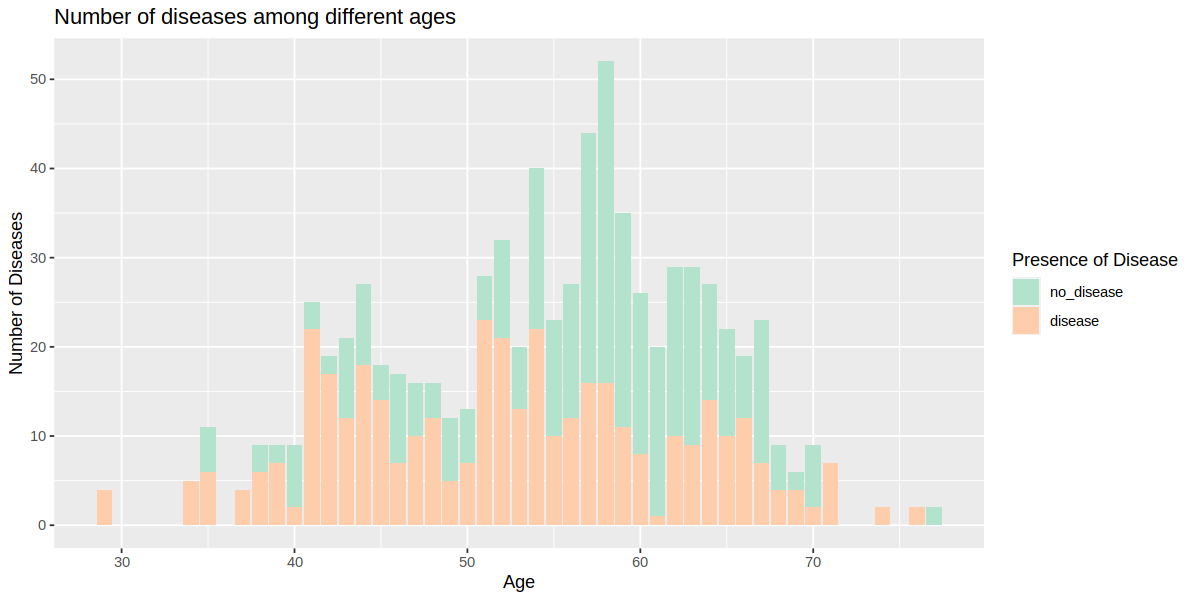

In [12]:
options(repr.plot.width = 10, repr.plot.height = 5)
heart_plot_age <- training_set |>
    ggplot(aes(x=age, fill=target)) + 
    geom_bar() + 
    labs(x = "Age",y = "Number of Diseases",fill = "Presence of Disease", title = "Number of diseases among different ages") +
    scale_fill_brewer(palette = "Pastel2")
heart_plot_age

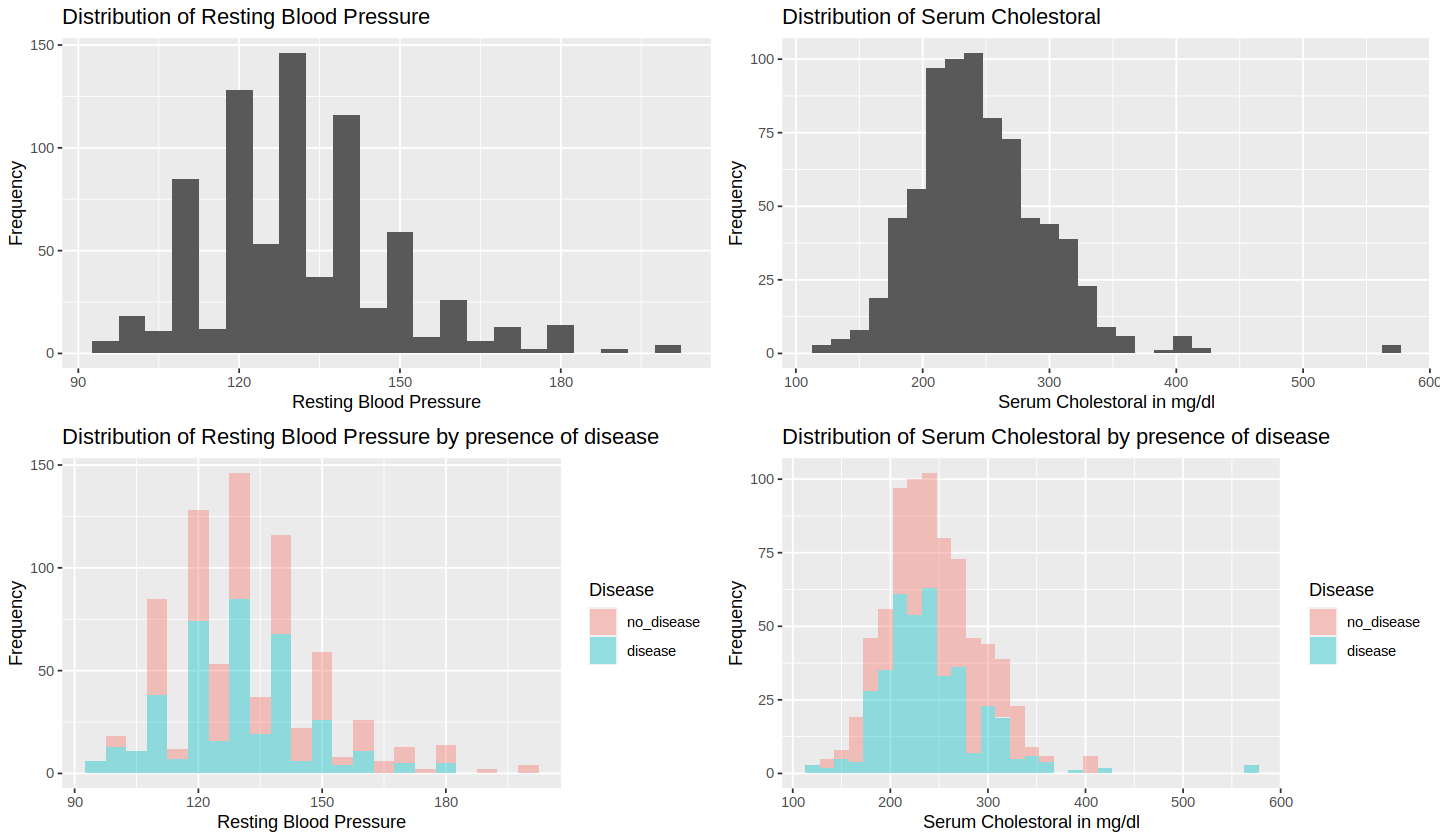

In [13]:
#Distribution of predictors
options(repr.plot.width = 12, repr.plot.height = 7)
rbp_distribution_plot <- training_set |> 
    ggplot(aes(x = trestbps)) +
    geom_histogram(binwidth = 5) +
    labs(title = "Distribution of Resting Blood Pressure", x = "Resting Blood Pressure", y = "Frequency") 

chol_distribution_plot <- training_set |> 
    ggplot(aes(x = chol)) +
    geom_histogram(binwidth = 15) +
    labs(title = "Distribution of Serum Cholestoral", x = "Serum Cholestoral in mg/dl", y = "Frequency")

rbp_distribution_plot2 <- training_set |>
    ggplot(aes(x=trestbps, fill = target)) +
    geom_histogram(binwidth = 5,alpha = 0.4) +
    labs(title = "Distribution of Resting Blood Pressure by presence of disease", 
         x = "Resting Blood Pressure", y = "Frequency", fill = "Disease")

chol_distribution_plot2 <- training_set |>
    ggplot(aes(x=chol, fill = target)) +
    geom_histogram(binwidth = 15,alpha = 0.4) +
    labs(title = "Distribution of Serum Cholestoral by presence of disease", 
         x = "Serum Cholestoral in mg/dl", y = "Frequency", fill = "Disease")

grid.arrange(rbp_distribution_plot, chol_distribution_plot, rbp_distribution_plot2, chol_distribution_plot2, nrow = 2)

 ** Based on the graph, we need to do some standardization 

This project focuses on age, sex, blood pressure, cholesterol levels, and target diagnosis, so other attributes will not be of use for this project. Target diagnosis is a categorical variable, so we will be using K-nearest neighbors classification to create our model.

### KNN Classification

To determine whether or not blood pressure, cholesterol levels, and age are good predictors, we will create the following 4 models: 
* Use blood pressure and cholesterol levels
* Use blood pressure and age
* Use cholesterol levels and age 
* Use blood pressure + cholesterol levels + age

For each model we will vfold our training data into 5 parts and tune them using cross-validation.

In [14]:
# 5-fold cross-validation
disease_vfold <- vfold_cv(training_set, v = 5, strata = target)

# knn specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

Once we have determined the optimal K value for each, we will test the models on the testing data. Through this, we can determine which model was the most effective.

Moreover, to visualize our models’ respective effectiveness, we will plot the accuracy of each model at every K-value we tested.

### Model 1: Use blood pressure and serum cholesterol

Warning message:
“tune samples were requested but there were 768 rows in the data. 763 will be used.”


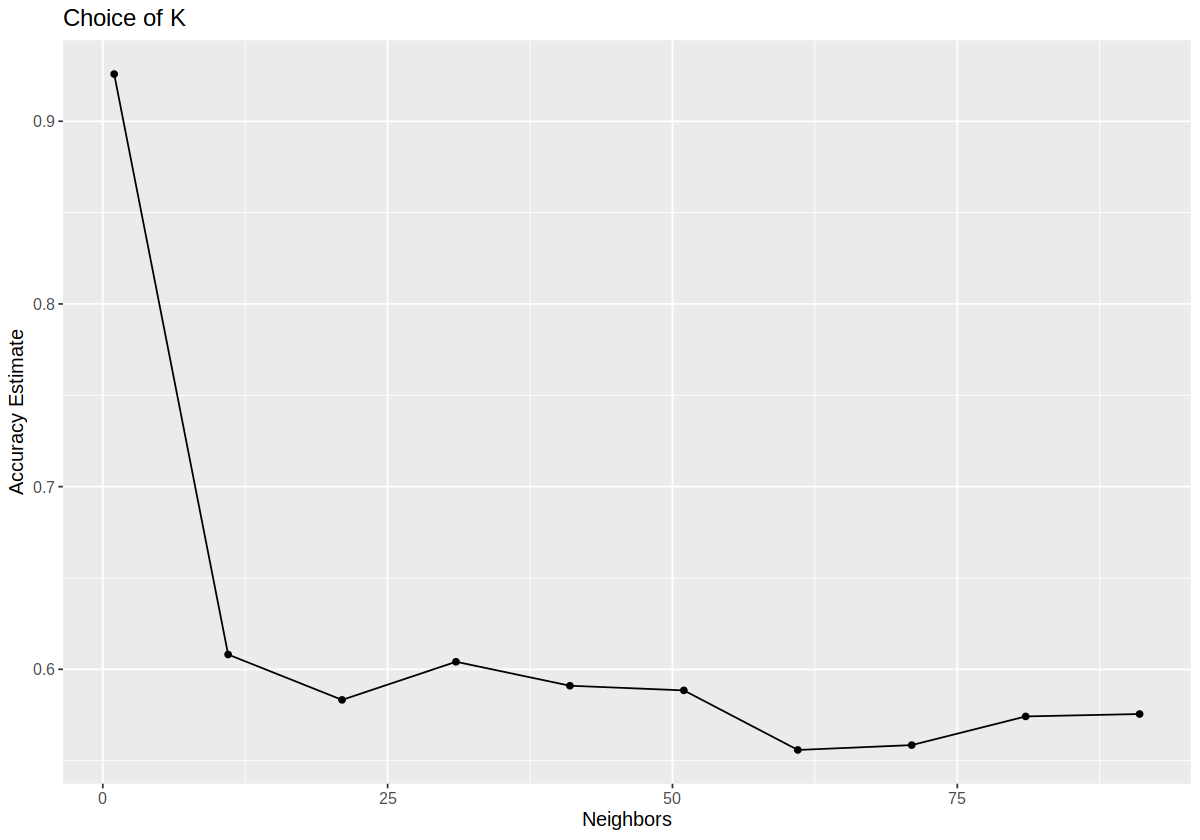

In [34]:
set.seed(123)
# create the standardization recipe
disease_recipe_chol_bp <- recipe(target ~ chol + trestbps, data = training_set) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

# fit the knn model 
knn_fit_chol_bp <- workflow() |>
  add_recipe(disease_recipe_chol_bp) |>
  add_model(knn_spec) |>
  fit(data = training_set)

# tuning the model
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 10))

#Collecting and visualizing the results
knn_results <- workflow() |>
  add_recipe(disease_recipe_chol_bp) |>
  add_model(knn_spec) |>
  tune_grid(resamples = disease_vfold, grid = k_vals) |>
  collect_metrics() 

accuracies_chol_bp <- knn_results |>
  filter(.metric == "accuracy")

options(repr.plot.width = 10, repr.plot.height = 7)
accuracy_chol_bp <- ggplot(accuracies_chol_bp, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate", title="Choice of K") + 
  theme(text = element_text(size = 12))

accuracy_chol_bp

In [16]:
best_result <- accuracies_chol_bp |>
    slice_max(`mean`, n = 1) |>
    mutate(accuracy = `mean`) |>
    select(`neighbors`, `accuracy`)
best_result

neighbors,accuracy
<dbl>,<dbl>
1,0.9258373


### Model 2: Use blood pressure and age

Warning message:
“tune samples were requested but there were 768 rows in the data. 763 will be used.”


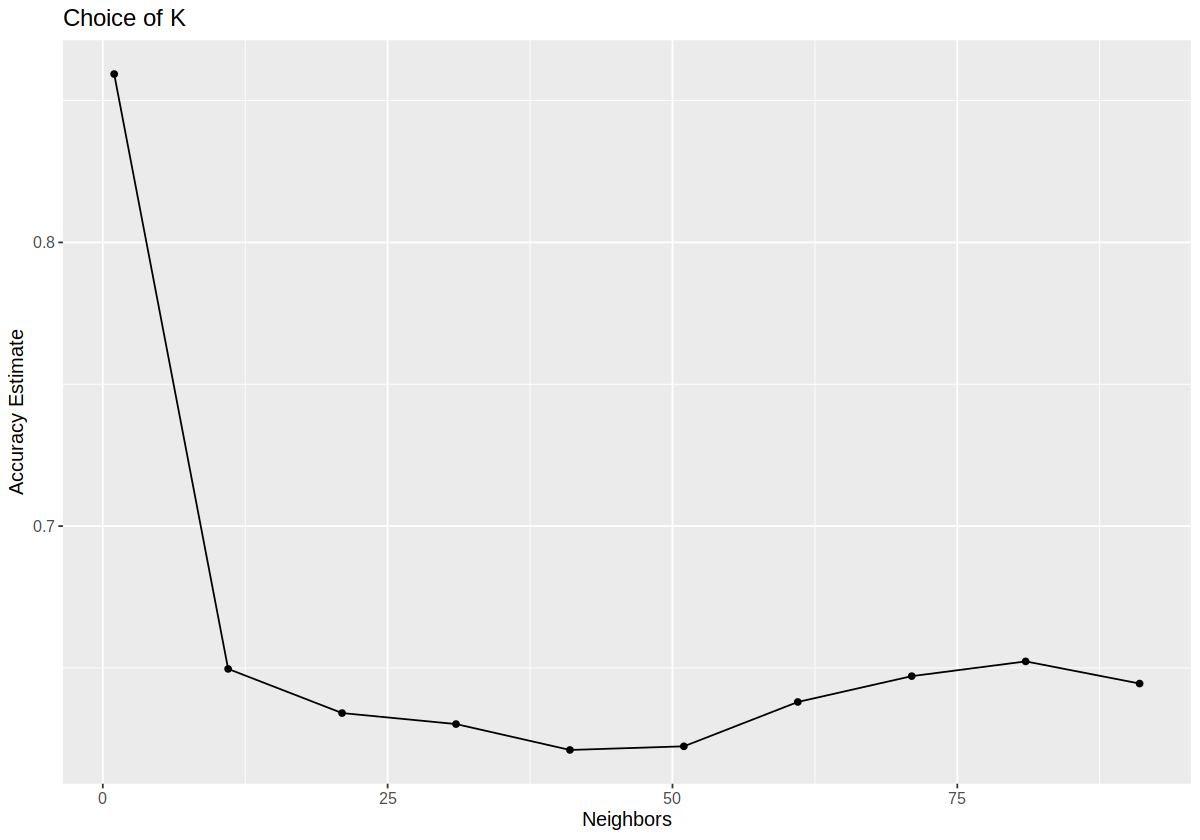

In [35]:
set.seed(123)
# create the standardization recipe
disease_recipe_bp_age <- recipe(target ~ trestbps + age, data = training_set) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

# fit the knn model 
knn_fit_bp_age <- workflow() |>
  add_recipe(disease_recipe_bp_age) |>
  add_model(knn_spec) |>
  fit(data = training_set)

# tuning the model
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 10))

#Collecting and visualizing the results
knn_results <- workflow() |>
  add_recipe(disease_recipe_bp_age) |>
  add_model(knn_spec) |>
  tune_grid(resamples = disease_vfold, grid = k_vals) |>
  collect_metrics() 

accuracies_bp_age <- knn_results |>
  filter(.metric == "accuracy")

options(repr.plot.width = 10, repr.plot.height = 7)
accuracy_bp_age <- ggplot(accuracies_bp_age, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate",title="Choice of K") + 
  theme(text = element_text(size = 12))

accuracy_bp_age

In [18]:
best_result <- accuracies_bp_age |>
    slice_max(`mean`, n = 1) |>
    mutate(accuracy = `mean`) |>
    select(`neighbors`, `accuracy`)
best_result

neighbors,accuracy
<dbl>,<dbl>
1,0.8593643


### Model 3: Use cholesterol levels and age

Warning message:
“tune samples were requested but there were 768 rows in the data. 763 will be used.”


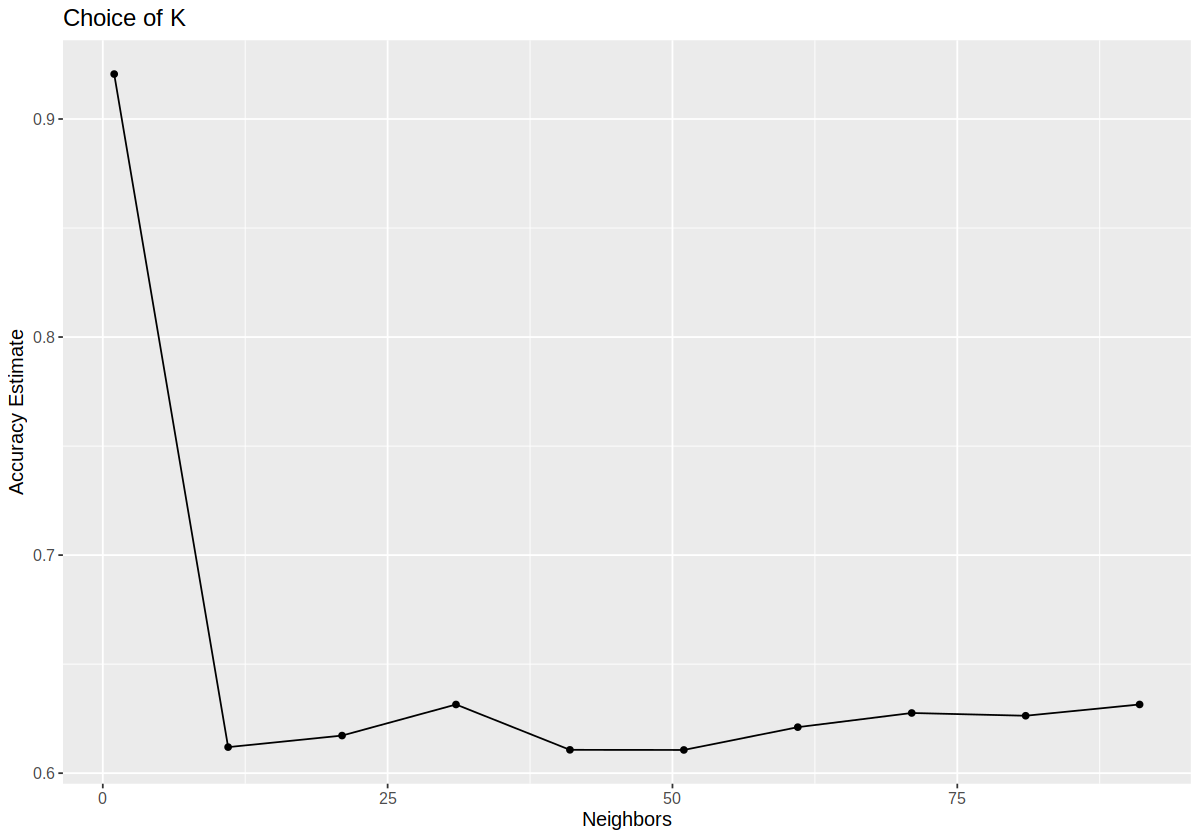

In [36]:
set.seed(123)
# create the standardization recipe
disease_recipe_chol_age <- recipe(target ~ chol + age, data = training_set) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

# fit the knn model 
knn_fit_chol_age <- workflow() |>
  add_recipe(disease_recipe_chol_age) |>
  add_model(knn_spec) |>
  fit(data = training_set)

# tuning the model
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 10))

#Collecting and visualizing the results
knn_results <- workflow() |>
  add_recipe(disease_recipe_chol_age) |>
  add_model(knn_spec) |>
  tune_grid(resamples = disease_vfold, grid = k_vals) |>
  collect_metrics() 

accuracies_chol_cge <- knn_results |>
  filter(.metric == "accuracy")

options(repr.plot.width = 10, repr.plot.height = 7)
accuracy_chol_age <- ggplot(accuracies_chol_cge, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate",title="Choice of K") + 
  theme(text = element_text(size = 12))

accuracy_chol_age

In [20]:
best_result <- accuracies_chol_cge |>
    slice_max(`mean`, n = 1) |>
    mutate(accuracy = `mean`) |>
    select(`neighbors`, `accuracy`)
best_result

neighbors,accuracy
<dbl>,<dbl>
1,0.9206083


### Model 4

Warning message:
“tune samples were requested but there were 768 rows in the data. 763 will be used.”


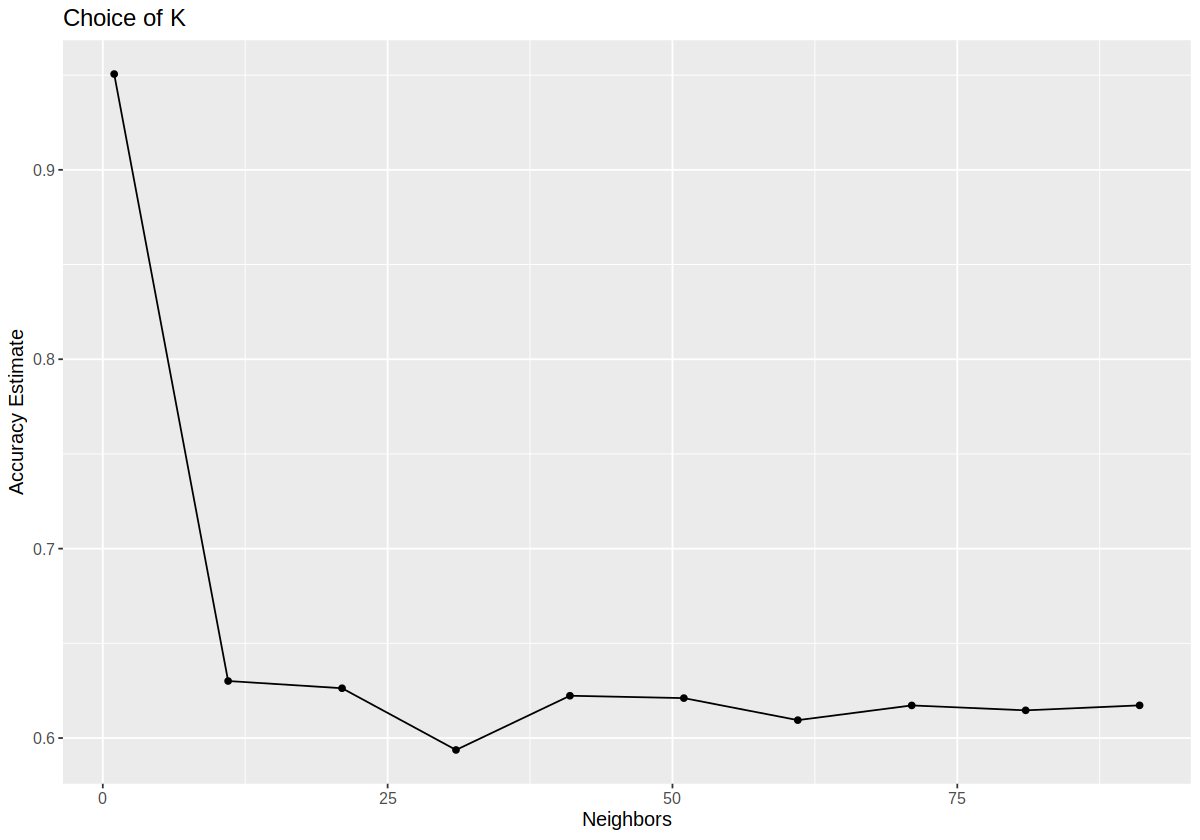

In [37]:
set.seed(123)
# create the standardization recipe
disease_recipe_all <- recipe(target ~ chol + age + trestbps , data = training_set) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

# fit the knn model 
knn_fit_all <- workflow() |>
  add_recipe(disease_recipe_all) |>
  add_model(knn_spec) |>
  fit(data = training_set)

# tuning the model
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 10))

#Collecting and visualizing the results
knn_results <- workflow() |>
  add_recipe(disease_recipe_all) |>
  add_model(knn_spec) |>
  tune_grid(resamples = disease_vfold, grid = k_vals) |>
  collect_metrics() 

accuracies_all <- knn_results |>
  filter(.metric == "accuracy")

options(repr.plot.width = 10, repr.plot.height = 7)
accuracy_all <- ggplot(accuracies_all, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate",title="Choice of K") + 
  theme(text = element_text(size = 12))

accuracy_all

In [22]:
best_result <- accuracies_all |>
    slice_max(`mean`, n = 1) |>
    mutate(accuracy = `mean`) |>
    select(`neighbors`, `accuracy`)
best_result

neighbors,accuracy
<dbl>,<dbl>
1,0.9505639


All the above models suggest a k=1 neighbor as the best result. However, using k = 1 is not a reasonable number of neighbors in reality. Therefore, we do some further investigations, and found that there is a square root of N rule. Bohara (2023) suggested that setting $k = \sqrt{N}$ provides a quick and practical way to determine an initial k value for the KNN model. In this formula, N is the total number of observations in the dataset.

** Add some explanations about why k=1 is not a good choice?

In [23]:
# observations in the data
obs <- nrow(data)
neighbors <- sqrt(obs)
neighbors

[1] 32.01562

Based on the result, we will choose k = 32  as the optimal k value for this classification problem. Using k = 32, we then redo the three modles and try to find the model with the highest accuracy level.

### Model 1 using k =32

In [24]:
set.seed(123)
# create the standardization recipe
disease_recipe_bp_chol <- recipe(target ~ chol + trestbps, data = training_set) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

knn_spec_bp_chol <- nearest_neighbor(weight_func = "rectangular", neighbor = 32) |>
                            set_engine("kknn") |>
                            set_mode("classification")

# fit the knn model 
knn_fit_bp_chol <- workflow() |>
  add_recipe(disease_recipe_bp_chol) |>
  add_model(knn_spec_bp_chol) |>
  fit(data = training_set)

# Applying the specification and recipe to the testing dataset for predictions 
disease_predictions <- knn_fit_bp_chol |>
    predict(testing_set) |>
    bind_cols(testing_set)


disease_accuracy1 <- disease_predictions |> 
                        metrics(truth = target, estimate = .pred_class) |> 
                        filter(.metric == "accuracy")

disease_matrix1 <- disease_predictions |> 
                        conf_mat(truth = target, estimate = .pred_class)

In [25]:
disease_accuracy1

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.5447471


### Model 2 using k = 32

In [26]:
set.seed(123)
# create the standardization recipe
disease_recipe_bp_age <- recipe(target ~ trestbps + age, data = training_set) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

knn_spec_bp_age <- nearest_neighbor(weight_func = "rectangular", neighbor = 32) |>
                            set_engine("kknn") |>
                            set_mode("classification")

# fit the knn model 
knn_fit_bp_age <- workflow() |>
  add_recipe(disease_recipe_bp_age) |>
  add_model(knn_spec_bp_age) |>
  fit(data = training_set)

# Applying the specification and recipe to the testing dataset for predictions 
disease_predictions <- knn_fit_bp_age |>
    predict(testing_set) |>
    bind_cols(testing_set)


disease_accuracy2 <- disease_predictions |> 
                        metrics(truth = target, estimate = .pred_class) |> 
                        filter(.metric == "accuracy")

disease_matrix2 <- disease_predictions |> 
                        conf_mat(truth = target, estimate = .pred_class)

In [27]:
disease_accuracy2

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.618677


### Model 3 using k = 32

In [28]:
set.seed(123)
# create the standardization recipe
disease_recipe_chol_age <- recipe(target ~ chol + age, data = training_set) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())


knn_spec_chol_age <- nearest_neighbor(weight_func = "rectangular", neighbor = 32) |>
                            set_engine("kknn") |>
                            set_mode("classification")

# fit the knn model 
knn_fit_chol_age <- workflow() |>
  add_recipe(disease_recipe_chol_age) |>
  add_model(knn_spec_chol_age) |>
  fit(data = training_set)


# Applying the specification and recipe to the testing dataset for predictions 
disease_predictions <- knn_fit_chol_age |>
    predict(testing_set) |>
    bind_cols(testing_set)


disease_accuracy3 <- disease_predictions |> 
                        metrics(truth = target, estimate = .pred_class) |> 
                        filter(.metric == "accuracy")

disease_matrix3 <- disease_predictions |> 
                        conf_mat(truth = target, estimate = .pred_class)

In [29]:
disease_accuracy3

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6264591


### Model 4 using k = 32

In [30]:
set.seed(123)
# create the standardization recipe
disease_recipe_all <- recipe(target ~ chol + age + trestbps, data = training_set) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())


knn_spec_all <- nearest_neighbor(weight_func = "rectangular", neighbor = 32) |>
                            set_engine("kknn") |>
                            set_mode("classification")

# fit the knn model 
knn_fit_all <- workflow() |>
  add_recipe(disease_recipe_all) |>
  add_model(knn_spec_all) |>
  fit(data = training_set)


# Applying the specification and recipe to the testing dataset for predictions 
disease_predictions <- knn_fit_all |>
    predict(testing_set) |>
    bind_cols(testing_set)


disease_accuracy4 <- disease_predictions |> 
                        metrics(truth = target, estimate = .pred_class) |> 
                        filter(.metric == "accuracy")

disease_matrix4 <- disease_predictions |> 
                        conf_mat(truth = target, estimate = .pred_class)

In [31]:
disease_accuracy4

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6070039


Based on the above result, we found that Model 3 has the highest accuracy level, where chol and age are used as the predictors. Here are the summary stat for model 3:

In [32]:
disease_accuracy3

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6264591


In [33]:
disease_matrix3

            Truth
Prediction   no_disease disease
  no_disease         81      52
  disease            44      80

We are more interested in finding the correct diagnosis of having disease, therefore, we would refer to disease as positive, and no disease as negative.  

Based on the confusion matrix, we see that 81 observations were correctly predicted as no disease, and 80 were correctly predicted as having disease. Then we can calculate the following variables: 
* accuracy = $\frac{81 + 80}{81 + 52 + 44+ 80}$ = $0.626$
* precision = $\frac{80}{80+44} = 0.645$
* recall = $\frac{80}{52+80} = 0.606$

## Discussion

* Summarize what you found
* Discuss whether this is what you expected to find?
* Discuss what impact could such findings have?
* Discuss what future questions could this lead to?

## Reference

Bohara, R. K. (2023, October 29). How to find the optimal value of K in Knn?. Medium. https://medium.com/@rkbohara097/how-to-find-the-optimal-value-of-k-in-knn-2d5177430f2a 

Lapp, D. (2019, June 6). Heart disease dataset. Kaggle. https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset 

World Health Organization. “The Top 10 Causes of Death.” World Health Organization, WHO, 9 Dec. 2020, www.who.int/news-room/fact-sheets/detail/the-top-10-causes-of-death.